# Bicycle hire demand forecasting with Bigquery ML

## Introduction

In this analysis we will build a demand forecasting model that will predict demand for London bicycle hires. We will create a demand forecasting model from time series data using ARIMA models. We will leverage GCP Bigquery ML to generate the ARIMA model directly with SQL within GCP Bigquery. As data set to train the ARIMA model on, we will use the London Bicycle hires data set, which contains data about bicyle hire events for 852 bicycle hire station across London. This data set can be found in Bigquery public data sets `bigquery-public-data.london_bicycles.cycle_hire`.

To perform this analysis you will need to set up a GCP account, enable the bigquery APIs and authenticate yourself against GCP.

**Disclaimer: Note that peforming this analysis will incur costs on your GCP billing account, so use at your own responsibility!** 

## Theretical background on ARIMA models


Before we will start with building our time series forecasting model, let's provide some theoretical background about ARIMA models.

**ARIMA** stands for **autoregressive integrated moving average**.
The ARIMA model involves the autoregressive (AR), differencing (I), and moving average (MA) components. Here are the relevant formulas for each component:

1. **AutoRegressive (AR)** Component:
The AR component represents the relationship between the current value and its previous values. It is denoted by the order "p," which indicates the number of previous time steps considered for the prediction.

The AR(p) model can be represented as:

y(t) = c + φ(1)*y(t-1) + φ(2)*y(t-2) + ... + φ(p)*y(t-p) + ε(t)

Where:
- y(t): The value of the time series at time t.
- c: A constant term (intercept) in the model.
- φ(i): The autoregressive parameter for lag i.
- ε(t): The error term (residual) at time t, representing the difference between the predicted value and the actual value.

2. **Integrated (I)** component:
The I component represents the differencing process applied to make the time series data stationary. It is denoted by the order "d," which indicates how many times differencing is applied.

The differencing process can be represented as:

y'(t) = y(t) - y(t-d)

Where:
- y'(t): The differenced time series at time t.
- y(t): The original time series at time t.
- d: The order of differencing.

3. **Moving Average (MA)** component:
The MA component captures the relationship between the current value and the past forecast errors (residuals). It is denoted by the order "q," which indicates how many past forecast errors are considered in the model.

The MA(q) model can be represented as:

y(t) = c + θ(1)*ε(t-1) + θ(2)*ε(t-2) + ... + θ(q)*ε(t-q) + ε(t)

Where:
- y(t): The value of the time series at time t.
- c: A constant term (intercept) in the model.
- θ(i): The moving average parameter for lag i.
- ε(t): The error term (residual) at time t, representing the difference between the predicted value and the actual value.

The ARIMA model combines these components into one equation. For an ARIMA(p, d, q) model, the formula is:

y'(t) = c + φ(1)*y'(t-1) + φ(2)*y'(t-2) + ... + φ(p)*y'(t-p) + θ(1)*ε(t-1) + θ(2)*ε(t-2) + ... + θ(q)*ε(t-q) + ε(t)

Where:
- y'(t): The differenced time series at time t.
- c: A constant term (intercept) in the model.
- φ(i): The autoregressive parameter for lag i.
- θ(i): The moving average parameter for lag i.
- ε(t): The error term (residual) at time t, representing the difference between the predicted value and the actual value.

Estimating the model parameters φ(i), θ(i), and the constant c, along with determining the appropriate order of differencing "d," is essential for building an effective ARIMA model for time series analysis and forecasting.

We are now ready to start with the analysis, which will be performed mostly using SQL. However, we will use some Python libraries for processing and visualizing the resulting SQL query sets. So let's import the required libraries.

In [729]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the default palette
sns.set_palette("Set2_r")

import matplotlib.pyplot as plot

## Time series data set creation

First we will create a time series data set from the transactional records in the source data set containing bicycle hire events. We will subsequently use this data set to train the ARIMA model on.  

To generate the time series data set we will need to perform some data cleaning, as station IDs are mixed up between `start_station_id` and `logical_terminal_id`. So we will clean and harmonize station IDs. After cleaning the data, we will select all bicycle hire events between 01-01-2016 and 31-01-2019. Finally, we will save the resulting time series as a Bigquery dataset at `bqmlforecast.time_series`.

Although we could build time series forecasting models for each bicyle hire station, we will will restrict the data set for this proof of concept analysis to only those four stations with the highest number of bicyle hires in order to speed up training time and reduce costs.

In [ ]:
%%bigquery

CREATE OR REPLACE TABLE bqmlforecast.time_series
OPTIONS(
  description="Time series data generated from London bicycle hires dataset"
) AS (
	
	WITH
		/* Clean and harmonize station IDs */
		cleaned_data AS (
				SELECT
						start_station_name,
						CASE 
								WHEN start_station_id IS NOT NULL and start_station_id <= 852 THEN start_station_id
								WHEN start_station_id IS NULL or start_station_id > 852 THEN NULL
						END AS start_id,
						CASE 
								WHEN start_station_logical_terminal IS NOT NULL THEN start_station_logical_terminal
								WHEN start_station_logical_terminal IS NULL AND start_station_id > 852 THEN start_station_id
								WHEN start_station_logical_terminal IS NULL AND start_station_id <= 852 THEN NULL
						END AS start_terminal,
						EXTRACT(DATE FROM TIMESTAMP(start_date)) AS hire_date
				FROM `bigquery-public-data.london_bicycles.cycle_hire`
		),
		/* Count nr of bicycle trips per station */
		transformed_data AS (
			SELECT
				start_station_name,
				CASE
						WHEN c.start_id IS NOT NULL and c.start_id <= 852 THEN c.start_id
						WHEN c.start_id IS NULL or c.start_id > 852 THEN s1.id
				END AS start_station_id,
				hire_date,
				COUNT(*) as nr_trips
			FROM cleaned_data c
			LEFT JOIN `bigquery-public-data.london_bicycles.cycle_stations` s1   
			ON c.start_terminal = CAST(s1.terminal_name as INTEGER)
			GROUP BY start_station_name, start_station_id, hire_date
			ORDER BY start_station_id, hire_date
		),
		/* Select stations with most bikerides */
		top_stations AS (
			SELECT start_station_id
			FROM transformed_data
			GROUP BY start_station_id
			ORDER by sum(nr_trips) DESC
			LIMIT 4
		),
		/* Select training data */
		training_data AS (
			SELECT *
			FROM transformed_data
			WHERE 
				start_station_id IN (select start_station_id from top_stations)
			AND hire_date BETWEEN DATE('2016-01-01') AND ('2019-12-31')
		)
		
	SELECT
		start_station_id,
		start_station_name,
		hire_date,
		EXTRACT(DAYOFYEAR FROM hire_date) AS doy,
		EXTRACT(DAYOFWEEK FROM hire_date) AS dow,
		FORMAT_DATE("%A", hire_date) AS dow_name,
		EXTRACT(MONTH FROM hire_date) AS month,
		EXTRACT(YEAR FROM hire_date) AS year,

		nr_trips
	FROM
		training_data
)

## Exploratory data analysis

Now that we have build or time series data set containing bicycle hire events for four stations, let's perform some exploratory data analysis to check whether we can obsserve patterns in the data.

In [ ]:
%%bigquery time_series_df

SELECT * FROM bqmlforecast.time_series

In [196]:
time_series_df["doy"] = time_series_df['doy'].astype("int32")
time_series_df["dow"] = time_series_df['dow'].astype("int32")
time_series_df["year"] = time_series_df['year'].astype("int32")
time_series_df["month"] = time_series_df['month'].astype("int32")
time_series_df["nr_trips"] = time_series_df['nr_trips'].astype("int32")
time_series_df["dow_name"] = time_series_df['dow_name'].astype("category")
time_series_df.set_index('hire_date', inplace=True)
time_series_df.drop("YEAR", axis=1, inplace=True)
time_series_df.drop("MONTH", axis=1, inplace=True)
time_series_df.head()

,start_station_id,start_station_name,hire_date,doy,dow,dow_name,nr_trips,year
0,154,"Waterloo Station 3, Waterloo",2018-05-13,133,1,Sunday,27,2018
1,14,"Belgrove Street , King's Cross",2018-05-13,133,1,Sunday,77,2018
2,303,"Albert Gate, Hyde Park",2018-05-13,133,1,Sunday,303,2018
3,191,"Hyde Park Corner, Hyde Park",2018-05-13,133,1,Sunday,559,2018
4,303,"Albert Gate, Hyde Park",2016-12-18,353,1,Sunday,92,2016


We can visualize evolution of bicycle hire demand across the whole year. We can observe that some time series exhibit yearly seasonality effects. For instance, the stations at Albert Gate and Hide park have a higher bicycle hire demand in spring and summer.

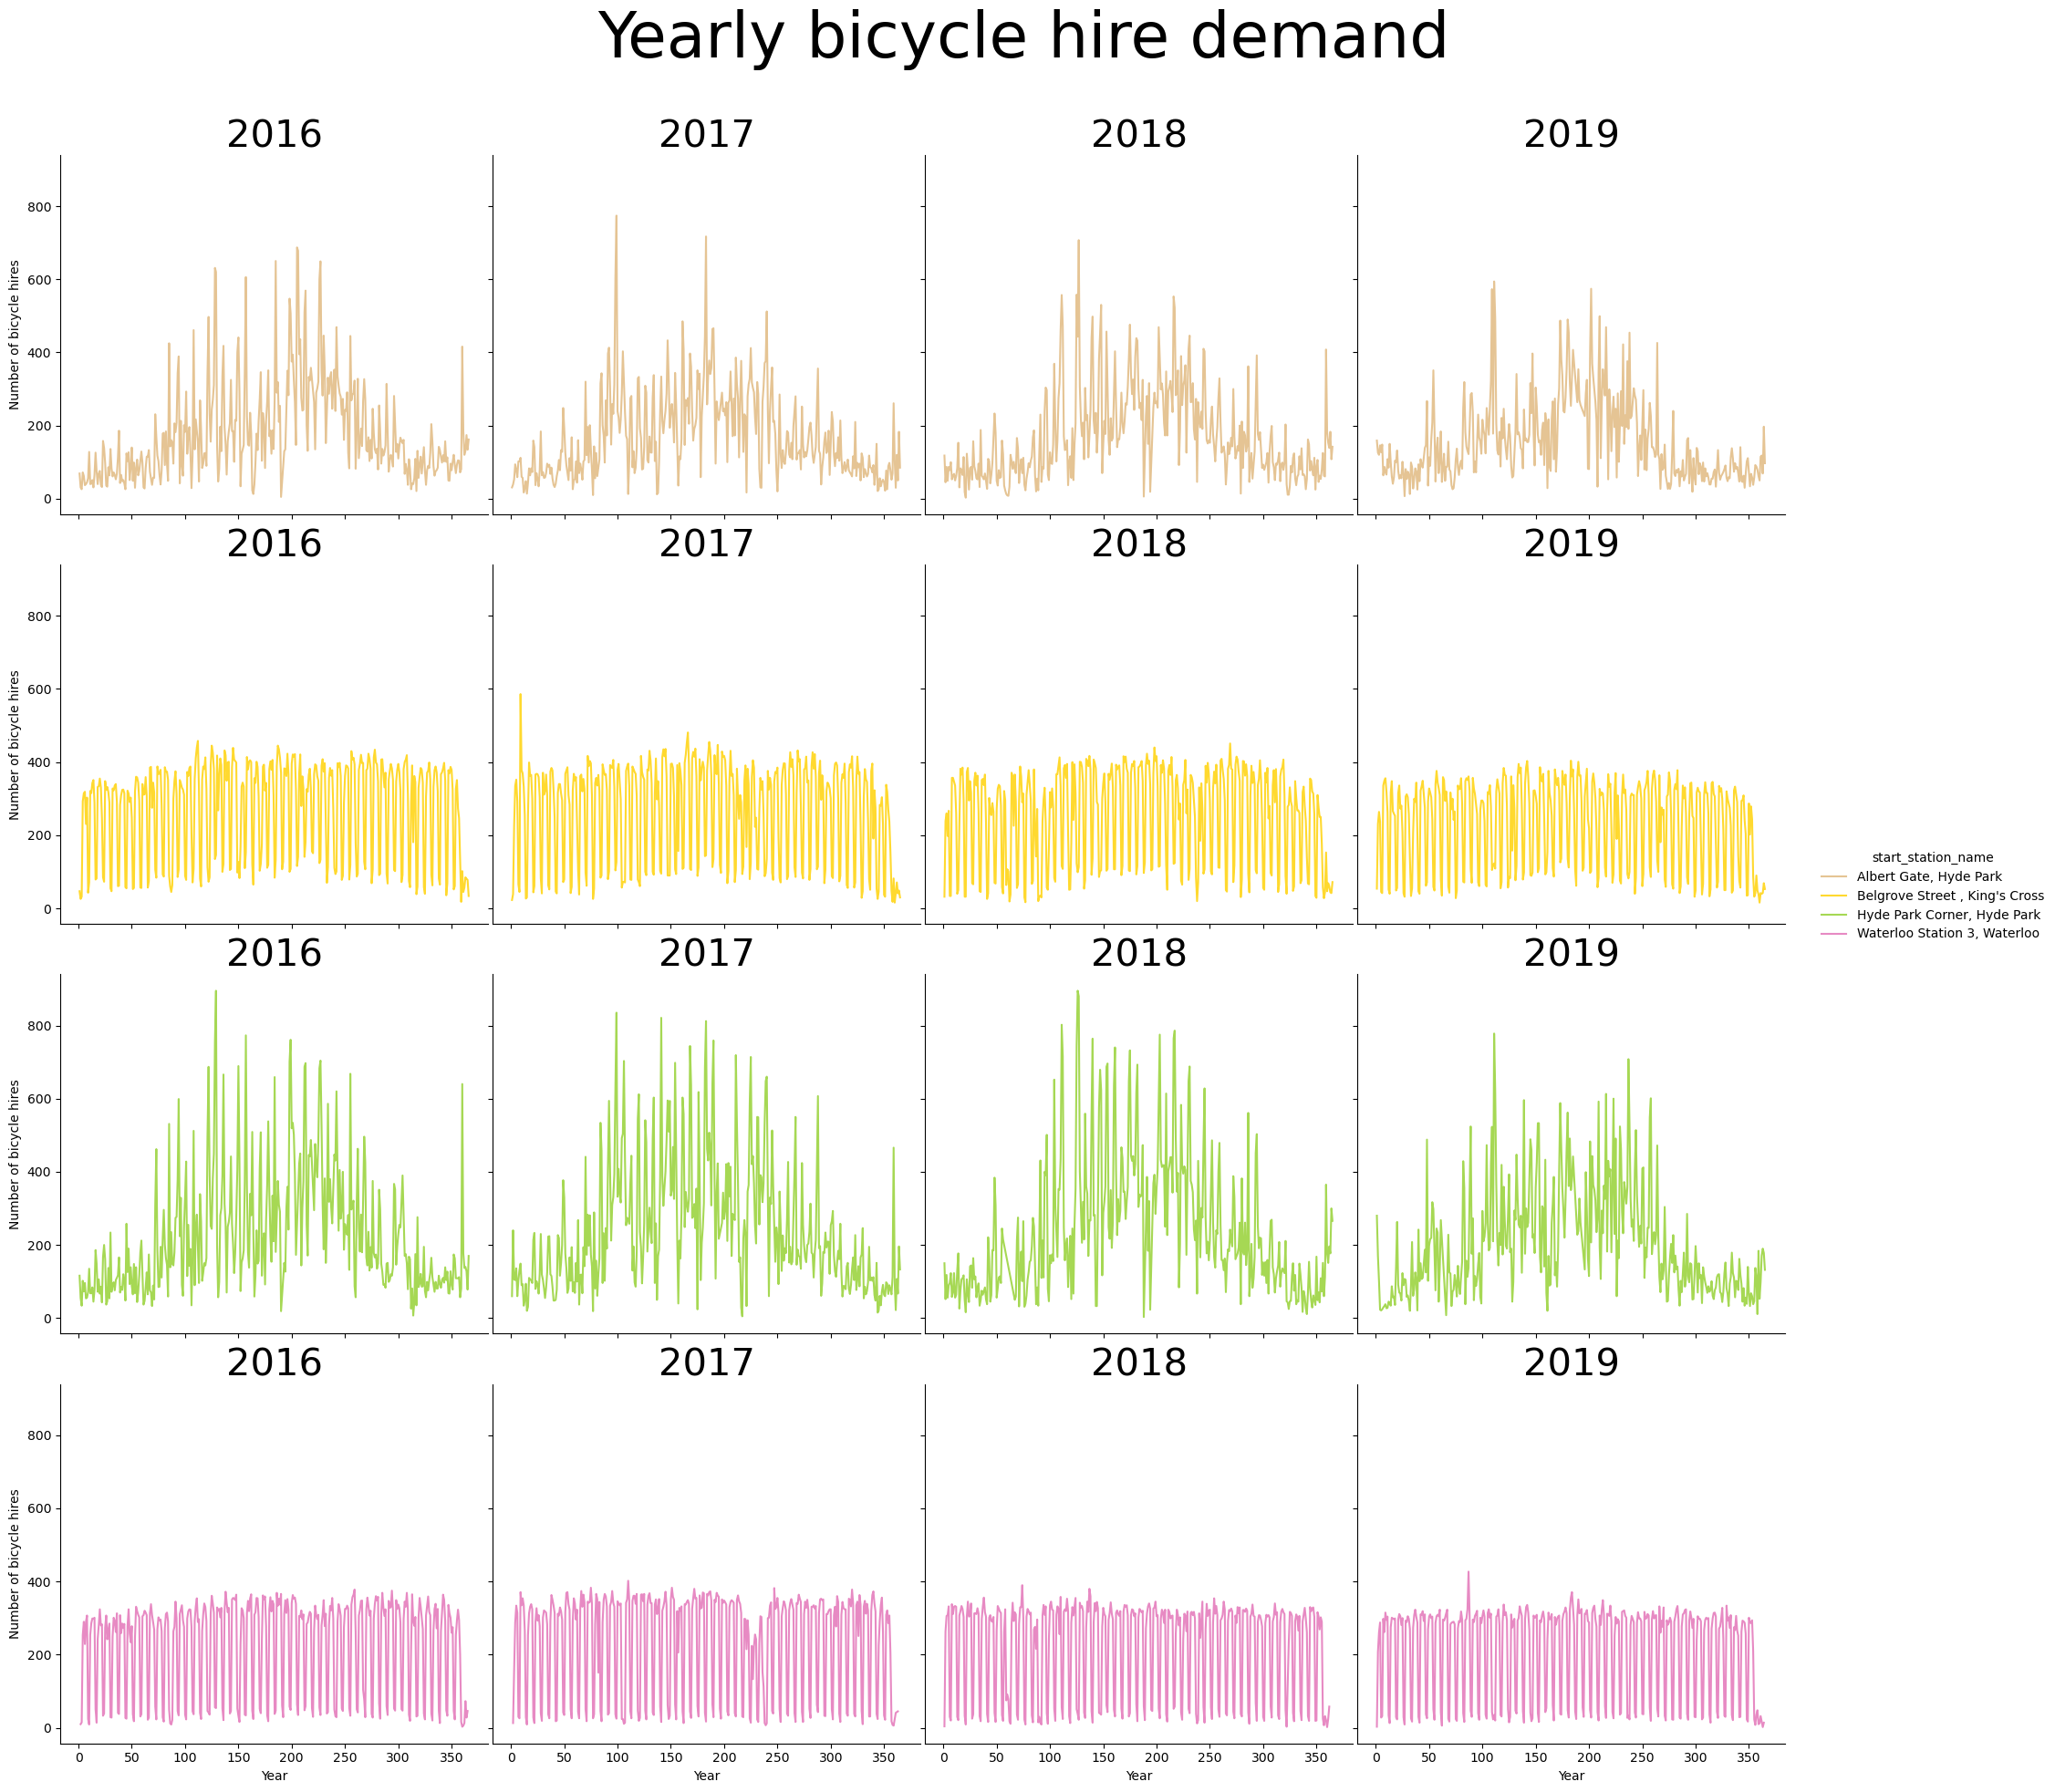

In [871]:
p = sns.relplot(
    data=time_series_df,
    x="doy",
    y="nr_trips",
    col="year",
    row="start_station_name",
    hue="start_station_name",
    kind="line"
)
(
    p.set_axis_labels("Year", "Number of bicycle hires")
    .set_titles("{col_name}", size=30)
    .tight_layout(w_pad=0)
)

p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Yearly bicycle hire demand", size=50);

Similarly we can also have a look at daily bicicyle hire demand. We can observe that some stations exhibit weekly trends. For instance, Belgrove street and Waterloo Station have a dip in bicycle hires during the weekend, suggesting that those stations are mainly used for commuting to work.

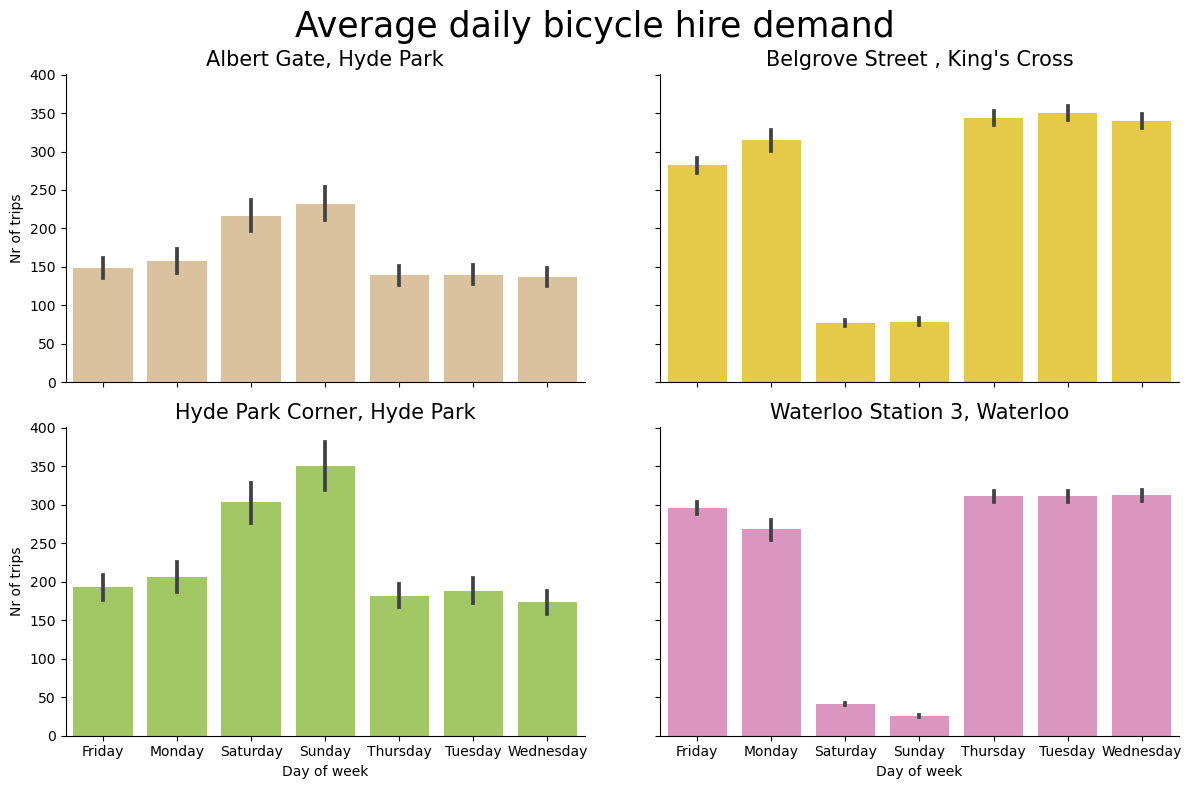

In [867]:
p = sns.catplot(
    data=time_series_df,
    x="dow_name",
    y="nr_trips",
    col="start_station_name",
    col_wrap=2,
    kind="bar",
    height=4,
    aspect=1.5,
    hue="start_station_name",
    dodge = False
)
(
    p.set_axis_labels("Day of week", "Nr of trips")
    .set_titles("{col_name}", size=15)
    .tight_layout(w_pad=5)
)

p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Average daily bicycle hire demand", size=25);

Those trends are even more pronounced on a line plot.

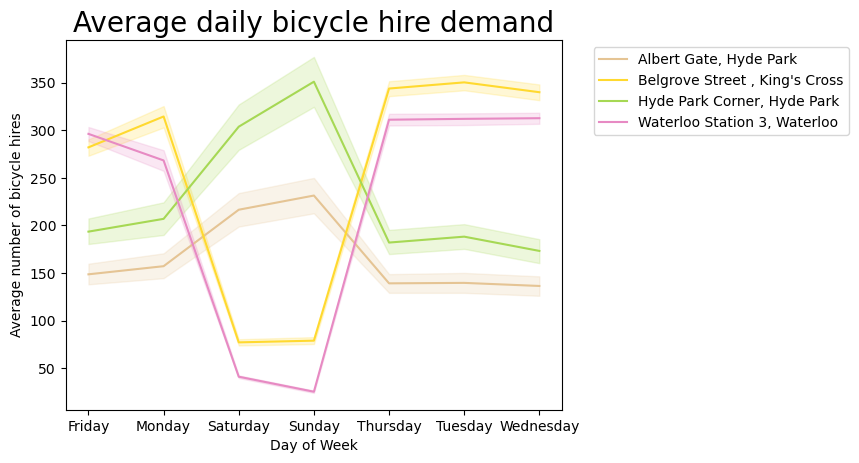

In [872]:
p = sns.lineplot(
    data=time_series_df,
    x="dow_name",
    y="nr_trips",
    hue="start_station_name",
    errorbar=("ci", 90),
)

p.set(xlabel='Day of Week', ylabel='Average number of bicycle hires')
plt.title("Average daily bicycle hire demand", size=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## Model training

After we have explored our time series data, we can now proceed with building an ARIMA model using GCP Bigquery ML. Bigquery ML offers the `ARIMA_PLUS` model for time series forecasting.

`ARIMA_PLUS` is a variant of the ARIMA model that is specifically designed for BigQuery. It is a statistical model that can be used to forecast future values for time series. 

The `ARIMA_PLUS` model is more computationally expensive than the standard ARIMA model, but it can handle irregular time intervals, missing data, and outliers. This makes it a good choice for forecasting time series that are not well-behaved.

By leveraging Bigquery ML, we can build the time series model directly in Bigquery with SQL.
We will start by creating a schema `bqmlforecast.arima_model` that will store the trained ARIMA model in Bigquery.

In [ ]:
%%bigquery
CREATE SCHEMA IF NOT EXISTS `bqmlforecast.arima_model`

To create a time series forecasting model in BigQuery ML, wecan use the `CREATE MODEL` statement. The `CREATE MODEL` statement takes a number of parameters, including the time series data, the forecasting horizon, and the ARIMA_PLUS model parameters. We will also set the holiday region `GB` (Great Brittain) as this might be an important feature that might affect bicycle hire demand.

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL bqmlforecast.arima_model
OPTIONS(
	MODEL_TYPE='ARIMA',
	TIME_SERIES_TIMESTAMP_COL='hire_date',
	TIME_SERIES_DATA_COL='nr_trips',
	TIME_SERIES_ID_COL='start_station_id',
	HOLIDAY_REGION='GB'

) AS

SELECT
	start_station_id,
	hire_date,
	nr_trips
FROM
	bqmlforecast.time_series

After the model has been trained, we can inspect the model coefficients as follows:

In [ ]:
%%bigquery model_coefficients_df

SELECT *
FROM ML.ARIMA_COEFFICIENTS(MODEL bqmlforecast.arima_model)

In [174]:
model_coefficients_df.head().style.hide(axis=0)

start_station_id,ar_coefficients,ma_coefficients,intercept_or_drift
14,[],[-0.88804523 -0.15159116 0.634741 -0.0058049 -0.56891582],-0.037513
154,[],[-0.62305953 -0.54838017 0.6434416 0.22514419 -0.67999609],0.002616
191,[],[-0.70836859 -0.38657216 0.58073096 0.21043303 -0.69478661],-0.043054
303,[],[-0.76507754 -0.15693936 0.2686316 0.03420158 -0.34631814],0.000000


## Model Evaluation

Now that we have trained model, we can use the Bigquery function `ML.EVALUATE` to evaluate peformance of the fitted model. This doesn't require new data as input. The resulting output reports metrics (including log_likelihood, AIC, and variance) for all ARIMA candidate models (i.e. for each bicycle start station) characterized by different (p, d, q, has_drift) tuples, as well as other information about seasonality, holiday effects, spikes-and-dips outliers, etc.

In [ ]:
%%bigquery model_eval_df

SELECT *
FROM ML.EVALUATE(MODEL bqmlforecast.arima_model)

When inspecting the evaluating results, we can observe that the ARIMA models have identified weekly and yearly periods, which is consistnt with the patterns we observed in the exploratory analysis of the time series data.

In [299]:
model_eval_df.head()

,start_station_id,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,14,0,1,5,True,-6976.549061,13967.098122,823.356789,"[WEEKLY, YEARLY]"
1,154,0,1,5,True,-6445.641731,12905.283461,403.416782,"[WEEKLY, YEARLY]"
2,191,0,1,5,True,-8182.911290,16379.822580,4297.355492,"[WEEKLY, YEARLY]"
3,303,0,1,5,False,-7705.564285,15423.128570,2243.367611,"[WEEKLY, YEARLY]"


## Bicycle hire demand forecasting

After we have created a time series forecasting model, we can use the `FORECAST` function to forecast future values for the time series. The `FORECAST` function takes the model, the forecasting horizon, and the start date of the forecast as input.

We will forecast bicycle demand values with a 90% confidence interval for the next 14 days following our training data.

In [ ]:
%%bigquery forecast_df

SELECT
		*
FROM 
	ML.FORECAST(
		MODEL bqmlforecast.arima_model,
        STRUCT(
            14 AS horizon,
            0.90 AS confidence_level)
	)


For visualization purposes we will also retrieve the historical time series data for the year 2019.

In [ ]:
%%bigquery historical_df

SELECT *
FROM bqmlforecast.time_series
WHERE hire_date BETWEEN DATE('2019-12-01') AND ('2019-12-31')


We will quickly cast a few data types to make them more compatible with Seaborn for plotting.

In [336]:
historical_df["doy"] = historical_df['doy'].astype("int32")
historical_df["dow"] = historical_df['dow'].astype("int32")
historical_df["year"] = historical_df['YEAR'].astype("int32")
historical_df["month"] = historical_df['MONTH'].astype("int32")
historical_df["nr_trips"] = historical_df['nr_trips'].astype("int32")
historical_df["dow_name"] = historical_df['dow_name'].astype("category")
historical_df.set_index('hire_date', inplace=True)
historical_df.drop("YEAR", axis=1, inplace=True)
historical_df.drop("MONTH", axis=1, inplace=True)
historical_df.head()

,start_station_id,start_station_name,doy,dow,dow_name,nr_trips,year,month
hire_date,,,,,,,,
2019-12-01,303,"Albert Gate, Hyde Park",335,1,Sunday,110,2019,12
2019-12-01,154,"Waterloo Station 3, Waterloo",335,1,Sunday,21,2019,12
2019-12-01,14,"Belgrove Street , King's Cross",335,1,Sunday,49,2019,12
2019-12-01,191,"Hyde Park Corner, Hyde Park",335,1,Sunday,123,2019,12
2019-12-08,154,"Waterloo Station 3, Waterloo",342,1,Sunday,30,2019,12


To visualize historical and forecasted bicycle demand data together, We will merge the historical time series data with the forecasted time series data. The historical time series data consists of bicycle hires for 2019 whereas the forecasted time series data consists of predicted bicycle hires for the first two weeks of 2020.

In [778]:
historical = historical_df[["start_station_name", "date", "nr_trips"]].copy()
historical["event"] = "observed"
historical["upper"] = historical["nr_trips"]
historical["lower"] = historical["nr_trips"]

lookup_df = historical_df[["start_station_id", "start_station_name"]].drop_duplicates()
lookup_df.reset_index(drop=True)

forecasted = forecast_df.merge(lookup_df, on="start_station_id", how="inner")
forecasted.head()
forecasted = forecasted[
    [
        "start_station_name",
        "forecast_timestamp",
        "forecast_value",
        "prediction_interval_lower_bound",
        "prediction_interval_upper_bound",
    ]
].rename(
    columns={
        "forecast_timestamp": "date",
        "forecast_value": "nr_trips",
        "prediction_interval_lower_bound": "lower",
        "prediction_interval_upper_bound": "upper",
    }
)


forecasted["event"] = "forecasted (with 90% CI)"
forecasted["date"] = forecasted["date"].dt.date

merged_df = pd.concat([historical, forecasted])
merged_df["nr_trips"] = merged_df["nr_trips"].astype("int32")
merged_df["date"] = merged_df["date"].astype("datetime64[ns]")
merged_df['dow'] = merged_df['date'].dt.day_name()
merged_df = merged_df.sort_values(by="date")
merged_df = merged_df.reset_index(drop=True)

merged_df.head()

,start_station_name,date,nr_trips,event,upper,lower,dow
0,"Albert Gate, Hyde Park",2019-12-01,110,observed,110.0,110.0,Sunday
1,"Waterloo Station 3, Waterloo",2019-12-01,21,observed,21.0,21.0,Sunday
2,"Belgrove Street , King's Cross",2019-12-01,49,observed,49.0,49.0,Sunday
3,"Hyde Park Corner, Hyde Park",2019-12-01,123,observed,123.0,123.0,Sunday
4,"Albert Gate, Hyde Park",2019-12-02,74,observed,74.0,74.0,Monday


After merging both data sets, we can visualize the combined time series with historical and forecasted values for the top four stations with most bicycle hires. Each start station will have it's own time series with historical bicyle hire demand values for December 2019, followed by forecasted bicycle hire demand values for January 2020. The shaded area behind the forecasted bicycle hire demand values is the 90% confidence interval. We can observe that the forecasted time series values seem to capture yearly seasonal trends in bicycle hire demand for each bicycle hire station.

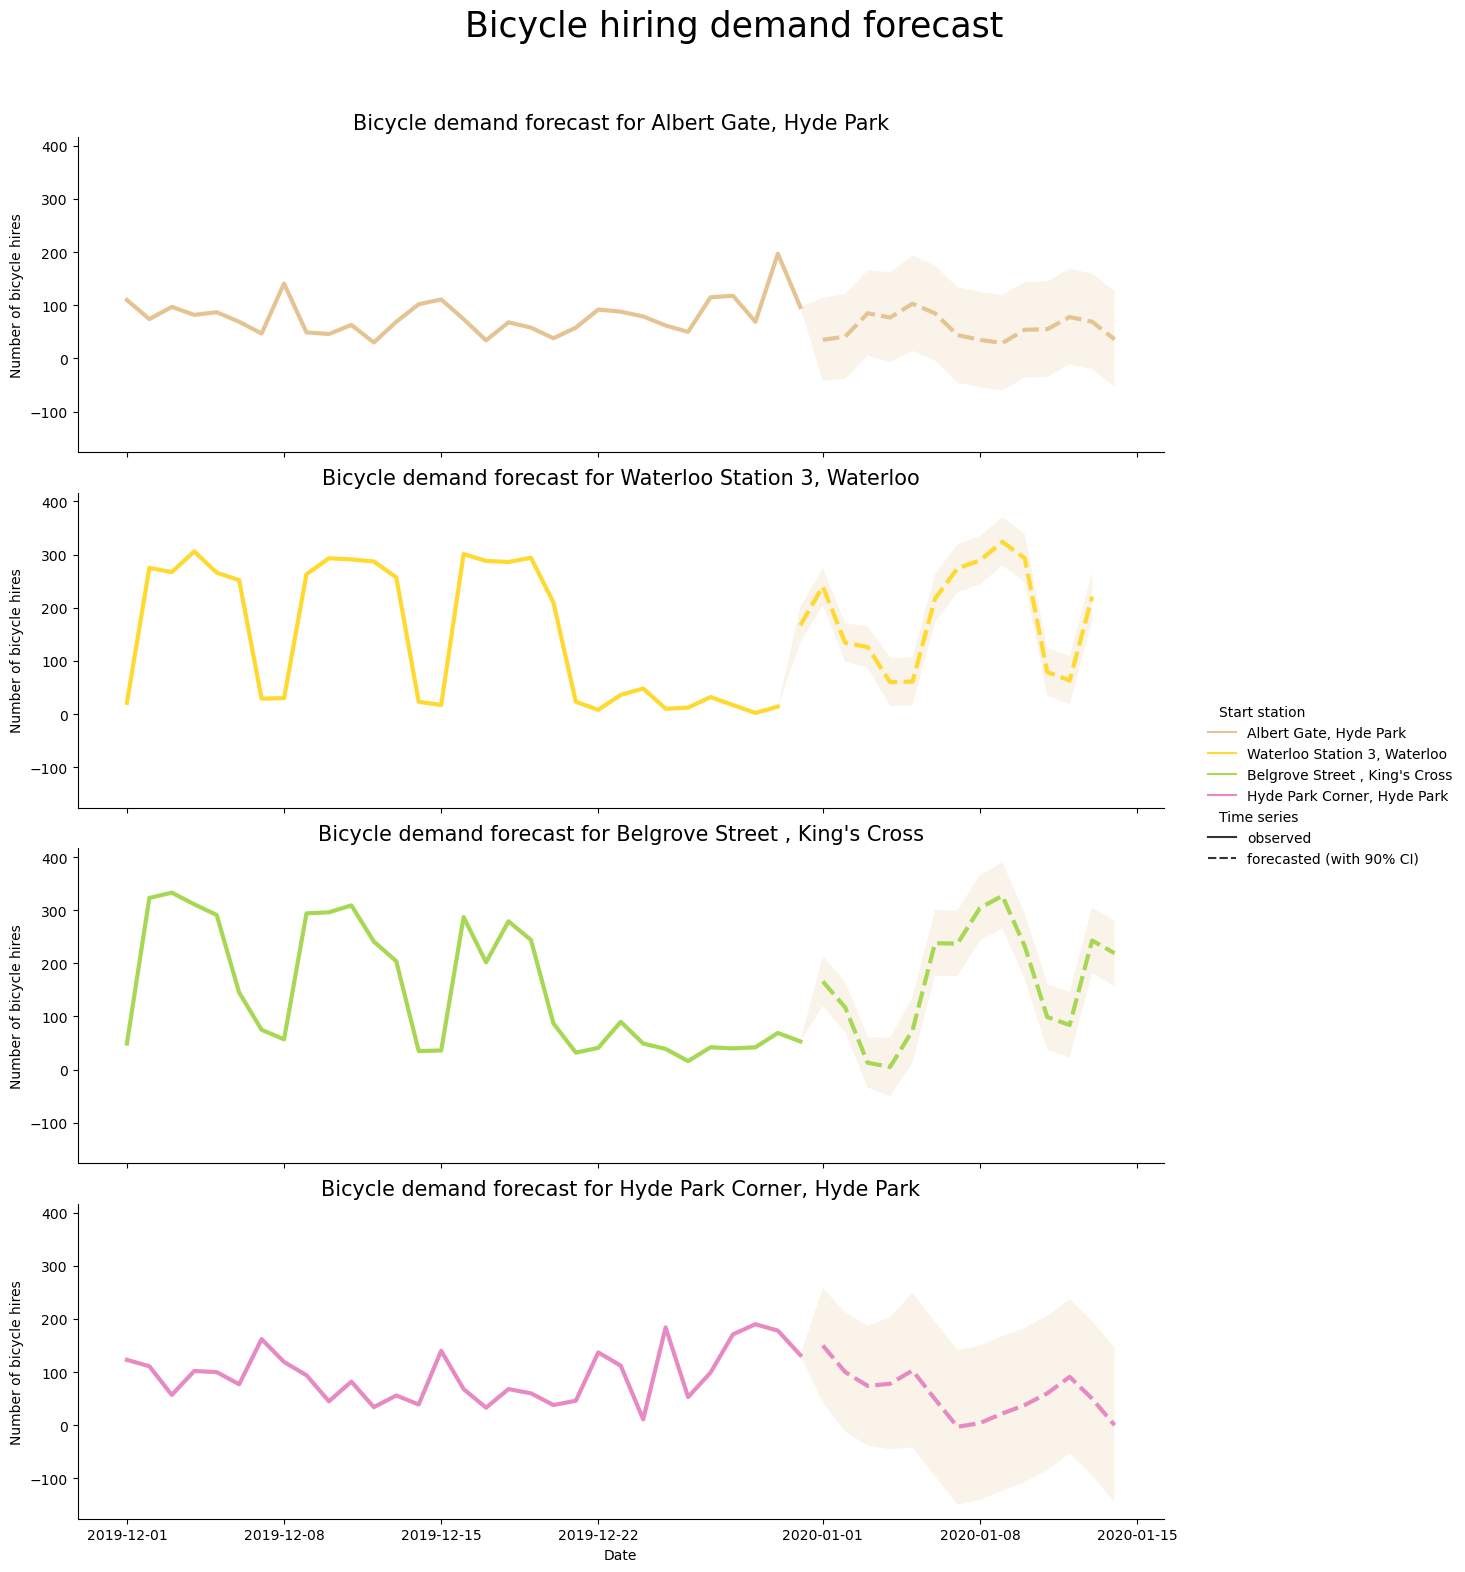

In [849]:
p = sns.relplot(
    data=merged_df,
    x="date",
    y="nr_trips",
    col="start_station_name",
    hue="start_station_name",
    kind="line",
    linewidth=3,
    style="event",
    style_order=["observed", "forecasted (with 90% CI)"],
    col_wrap=1,
    height=4,
    aspect=3
)

(
    p.set_axis_labels("Date", "Number of bicycle hires")
    .set_titles("Bicycle demand forecast for {col_name}", size=15)
    .tight_layout(w_pad=0)
)

p.legend.texts[0].set_text("Start station")
p.legend.texts[5].set_text("Time series")
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Bicycle hiring demand forecast", size=25)

for ax in p.axes.flat:
    start_station_name = ax.get_title().replace("Bicycle demand forecast for ", "")
    data_subset = merged_df[merged_df["start_station_name"] == start_station_name]
    ax.fill_between(
        data_subset["date"], data_subset["lower"], data_subset["upper"], alpha=0.2
    )

plt.show()

Similarly, we can also visualize mean bicycle hires per day of the week for each station. We will compute mean bicycle hires per day of the week for both historical and forecasted bicycle hires data and then compare both means in a grouped bar plot. We can see that the forecasted time series per day of week seem to capture the weekly trends in bicyle hire demand that can be observed in the historical data.

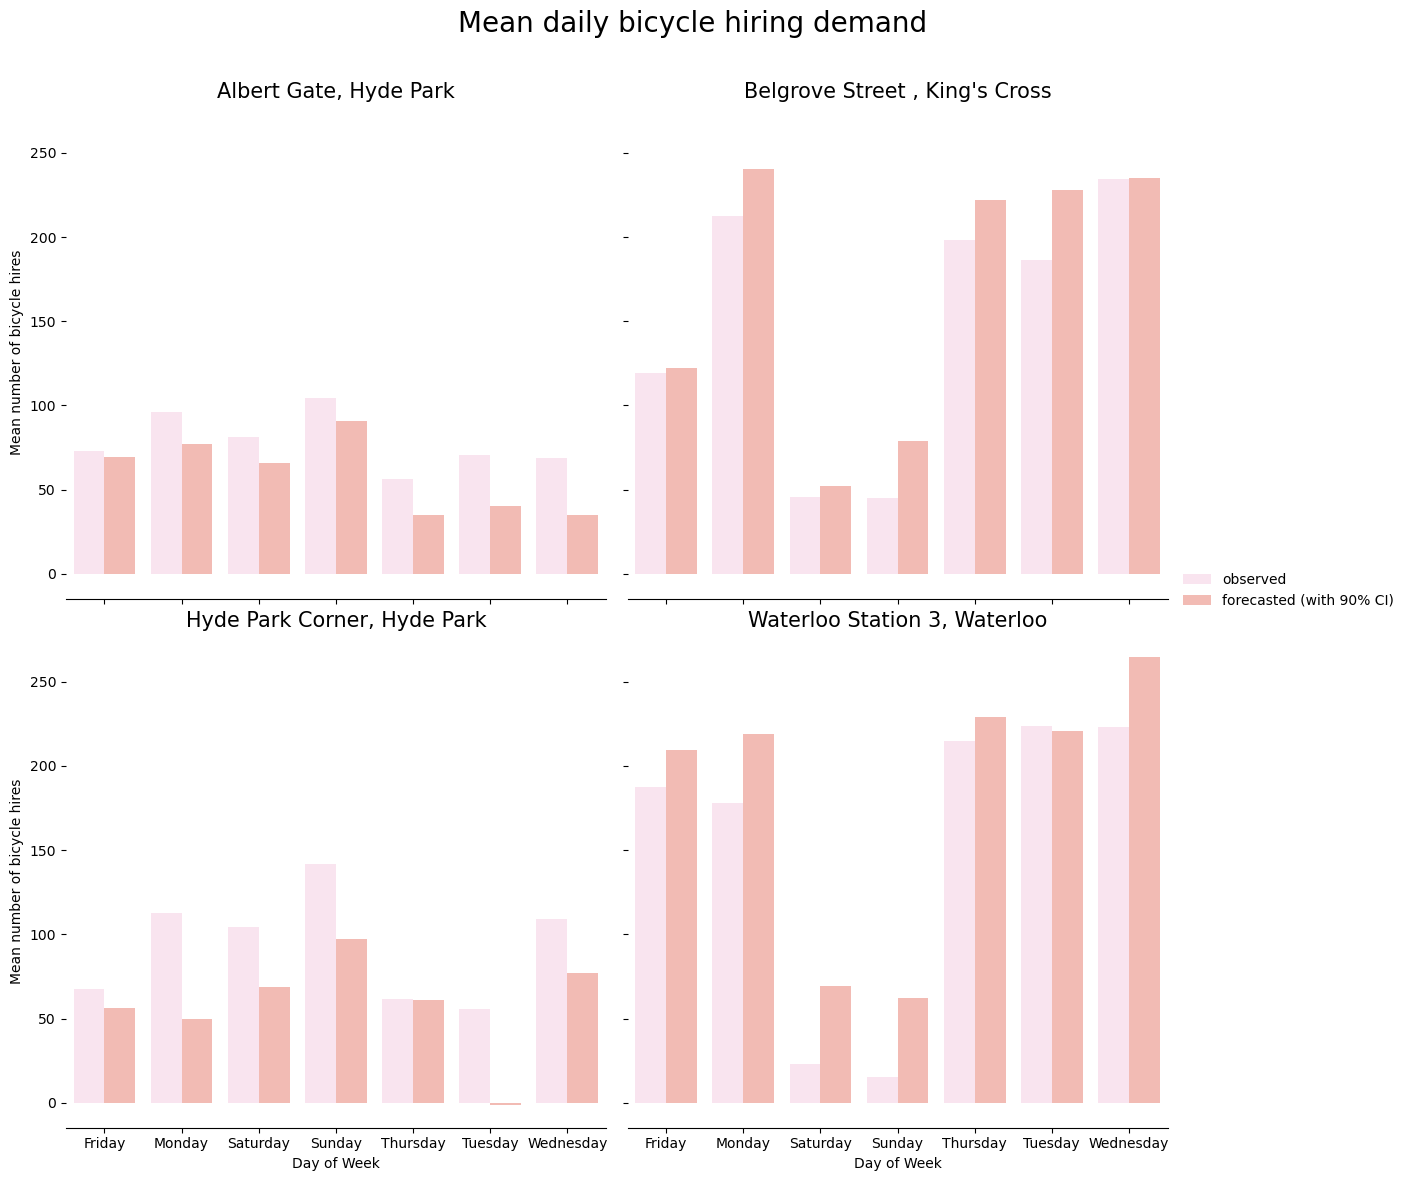

In [844]:
aggregated_df = (
    merged_df.groupby(by=["start_station_name", "dow", "event"])["nr_trips"]
    .mean()
    .reset_index()
)

g = sns.catplot(
    data=aggregated_df,
    kind="bar",
    x="dow",
    y="nr_trips",
    hue="event",
    hue_order=["observed", "forecasted (with 90% CI)"],
    col="start_station_name",
    col_wrap=2,
    errorbar=("ci", 90),
    alpha=0.6,
    height=6,
    palette="Set3_r",
)

g.despine(left=True)
g.set_axis_labels("Day of Week", "Mean number of bicycle hires")
g.set_titles("{col_name}", size=15)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Mean daily bicycle hiring demand", size=20)
g.legend.set_title("");

To conclude, this proof of concept analysis shows we can quickly build time series forecasting models using GCP Bigquery ML `ARIMA_PLUS` that can capture seasonal trends in time series data.